# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Utilities function to retrieve the state, reward and done when executing an action in the environment

In [5]:
def execute_action(env, brain_name, action):
    env_info = env.step(action)[brain_name]           # send all actions to tne environment
    states = env_info.vector_observations             # get next state (for each agent)
    rewards = env_info.rewards                        # get reward (for each agent)
    dones = env_info.local_done                       # see if episode finished
    return states, rewards, dones

### 4. Agent dependencies and hyperparameters

In [6]:
import random
from collections import namedtuple
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import copy

RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)

# hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 3e-1              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate for actor
LR_CRITIC = 1e-4        # learning rate for critic
EPS = 3e-3              # final layer weights uniform initialization parameter
NOISE_MAX = 0.2         # noise to add to action for exploration
NOISE_DECAY = 0.9       # noise decaying factor

# determine to use gpu or cpu for pytorch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 5. Critic and Actor models architectures

In [7]:
class Actor(nn.Module):
    def __init__(self, state_size=state_size, action_size=action_size):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)
        
        self.fc1.weight.data.uniform_(-EPS, EPS)
        self.fc2.weight.data.uniform_(-EPS, EPS)
        self.fc3.weight.data.uniform_(-EPS, EPS)
        
        self.tanh = nn.Tanh()

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_size=state_size, action_size=action_size):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256 + action_size, 128)
        self.fc3 = nn.Linear(128, 1)
        self.bn = nn.BatchNorm1d(256)
        
        self.fc1.weight.data.uniform_(-EPS, EPS)
        self.fc2.weight.data.uniform_(-EPS, EPS)
        self.fc3.weight.data.uniform_(-EPS, EPS)

    def forward(self, state, action):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(torch.cat([self.bn(x), action], dim=1)))
        x = self.fc3(x)
        return x

### 6. Replay buffer for past experiences

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=BUFFER_SIZE)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=BATCH_SIZE)

        states = torch.from_numpy(np.concatenate([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.concatenate([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.concatenate([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.concatenate([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.concatenate([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 7. Ornstein-Uhlenbeck process noise

In [9]:
class OrnsteinUhlenbeckNoise():
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.gauss(0., 1.) for i in range(len(x))])
        self.state = x + dx
        return self.state

### 8. Deep Deterministic Policy Gradient agent model

In [10]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """

        
        self.state_size = state_size
        self.action_size = action_size

        # step counter
        self.t = 0

        # Actor Networks
        self.actor = Actor(state_size, action_size).to(DEVICE)
        self.actor_target = Actor(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)

        # Critic Networks
        self.critic = Critic(state_size, action_size).to(DEVICE)
        self.critic_target = Critic(state_size, action_size).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        # hard update to start with the same weights
        self.soft_update(self.critic, self.critic_target, 1)
        self.soft_update(self.actor, self.actor_target, 1) 

        # Replay memory
        self.memory = ReplayBuffer(action_size)
        
        # noise added for exploration
        self.noise = OrnsteinUhlenbeckNoise(action_size)

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""

        self.t += 1
        self.memory.add(states, actions, rewards, next_states, dones)

        if len(self.memory) < BATCH_SIZE:
            return

        experiences = self.memory.sample()
        self.learn(experiences)

    def act(self, state, noise=0):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(DEVICE)
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        return np.clip(action + np.clip(self.noise.sample(), - NOISE_MAX, NOISE_MAX), -1, 1)

    def learn(self, experiences):

        states, actions, rewards, next_states, dones = experiences

        # update critic
        with torch.no_grad():
            actions_next = self.actor_target(next_states)
            Q_targets_next = self.critic_target(next_states, actions_next)
            Q_targets = rewards.reshape((-1, 1)) + (GAMMA * Q_targets_next * (1 - dones.reshape((-1, 1))))
        Q_expected = self.critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update actor
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # soft update target networks
        self.soft_update(self.critic, self.critic_target, TAU)
        self.soft_update(self.actor, self.actor_target, TAU)                     

    def soft_update(self, model, target_model, tau):
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


### 9. Agent training function

In [11]:
agent = Agent(state_size=state_size, action_size=action_size)

def ddpg(agent=agent, num_agents=num_agents, n_episodes=10000, max_t=1000):
    
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        
        score = np.zeros(num_agents)
        agent.noise.reset()
        
        for _ in range(max_t):
            actions = agent.act(states)
            
            next_states, rewards, dones = execute_action(env, brain_name, actions)
            
            agent.step(states, actions, rewards, next_states, dones) # send actions to the agent
            
            states = next_states                                # roll over states to next time step
            score += rewards
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        episode_score = np.max(score)

        scores_window.append(episode_score)       # save most recent score
        scores.append(episode_score)              # save most recent score

        torch.save(agent.actor.state_dict(), 'actor.pth')
        torch.save(agent.critic.state_dict(), 'critic.pth')

        print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}\tMin Score: {:.2f}'.format(i_episode,
                                                                                                 np.mean(scores_window),
                                                                                                 np.max(scores_window),
                                                                                                 np.min(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}\tMin Score: {:.2f}'.format(i_episode,
                                                                                                     np.mean(scores_window),
                                                                                                     np.max(scores_window),
                                                                                                     np.min(scores_window)))
            agent.noise.sigma *= NOISE_DECAY
        if (np.mean(scores_window)>=0.5) and (len(scores_window) == 100):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(agent.actor.state_dict(), 'actor_final.pth')
            torch.save(agent.critic.state_dict(), 'critic_final.pth')
            break
    
    return scores

### 10. Agent training results

In [12]:
scores = ddpg()

Episode 50	Average Score: 0.01	Max Score: 0.10	Min Score: 0.00
Episode 100	Average Score: 0.00	Max Score: 0.10	Min Score: 0.00
Episode 150	Average Score: 0.01	Max Score: 0.20	Min Score: 0.00
Episode 200	Average Score: 0.02	Max Score: 0.20	Min Score: 0.00
Episode 250	Average Score: 0.04	Max Score: 0.29	Min Score: 0.00
Episode 300	Average Score: 0.11	Max Score: 0.40	Min Score: 0.00
Episode 340	Average Score: 0.52	Max Score: 2.60	Min Score: 0.00
Environment solved in 340 episodes!	Average Score: 0.52


### 11. Agent training scores plot

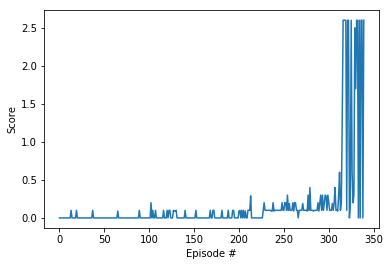

In [14]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()